In [5]:
#Paper 2(Numerical  Study of a Strongly Coupled Two-scale System with Nonlinear Dispersion, Section 5.3 Table 3)
#Scheme 2 pre computing (Numerics) congergence order in sapce (with varying macro mesh)
#Table 2 and Figure 6
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
set_log_active(False)


In [6]:
#Geometry for micro problem

L = 1.0 #lenght of domain
W = 1.0 #width of the domain

#center of ellipse
x_0 = 0.85
y_0 = 0.75
x_1 = 0.35
y_1  =  0.1
x_2 = 0.175
y_2  =  0.8
center0 = Point(x_0, y_0)
center1 = Point(x_1, y_1)
center2 = Point(x_2, y_2)

#axis of elllipse
horizontal_semi_axis_0 = 0.1
vertical_semi_axis_0 = 0.2
horizontal_semi_axis_1 = 0.30
vertical_semi_axis_1 = 0.08
horizontal_semi_axis_2 = 0.15
vertical_semi_axis_2 = 0.15

def Geometry1(ny):
    # Define domain for cell probem 
    #define geometry 1
    geometry = mshr.Rectangle(Point(0.0, 0.0), Point(1.0, 1.0)) \
         - mshr.Ellipse(center0, horizontal_semi_axis_0, vertical_semi_axis_0, 100) - mshr.Ellipse(center1, horizontal_semi_axis_1, vertical_semi_axis_1, 100) \
           - mshr.Ellipse(center2, horizontal_semi_axis_2, vertical_semi_axis_2, 100)
    
    # Build mesh
    mesh1 = mshr.generate_mesh(geometry, ny)
    return mesh1

In [7]:
#Solve the Stoke's problem

from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
set_log_active(False)
# Define domain for cell probem and B
#mesh = Geometry1(ny)

###periodic boundary conndition
class PeriodicBoundary(SubDomain):
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
    # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], 0) or near(x[1], 0)) and 
                (not ((near(x[0], 0) and near(x[1], 1)) or 
                        (near(x[0], 1) and near(x[1], 0)))) and on_boundary)
    def map(self, x, y):
        if near(x[0], 1) and near(x[1], 1):
            y[0] = x[0] - 1
            y[1] = x[1] - 1
        elif near(x[0], 1):
            y[0] = x[0] - 1
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 1
PbcUnit = PeriodicBoundary() 

# Construct facet markers
def STOKE(mesh):
    bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1) 
    for f in facets(mesh):
        mp = f.midpoint()
        if ((mp[0]- x_0)/horizontal_semi_axis_0)**2 + ((mp[1]-y_0)/vertical_semi_axis_0)**2 <=1: # elllipse is marked as 5
            bndry[f] = 5
        elif ((mp[0]- x_1)/horizontal_semi_axis_1)**2 + ((mp[1]-y_1)/vertical_semi_axis_1)**2 <=1: # elllipse is marked as 5
            bndry[f] = 5
        elif ((mp[0]- x_2)/horizontal_semi_axis_2)**2 + ((mp[1]-y_2)/vertical_semi_axis_2)**2 <=1: # elllipse is marked as 5
            bndry[f] = 5     

  
    #define a finite element space
    P0 = VectorElement('P', mesh.ufl_cell(), 2) #  Here  we used the Taylor-Hood element, second order Lagrange basis element for each component of velocity and first order for pressure   
    P1 = FiniteElement('P', mesh.ufl_cell(), 1) #  first order lagrange element  for pressure.
    TH = P0 * P1 

    W = FunctionSpace(mesh, TH, constrained_domain = PbcUnit) # Mixed function space with periodic boundary condition in outer boundary
    BC_value_circle = Constant((0, 0)) #Boundary value on the inner circle
    bc_circle = DirichletBC(W.sub(0), BC_value_circle, bndry, 5) #Impelemntation of BC on inner circle
    # Collect boundary conditions
    bcs = [bc_circle]

    nu = Constant(0.01)
    F = Expression(("10*(sin(2*pi*x[0])*sin(2*pi*x[1]))", '10*(sin(2*pi*x[0])*cos(2*pi*x[1]))'), degree =2)

    def stokes():
        # Define variational forms for Stokes
        def a(u,v):
            return inner(nu*grad(u), grad(v))*dx
        def b(p,v):
            return p*div(v)*dx
        def L(v):
            return inner(F, v)*dx
        
        # Solve the problem
        B, p = TrialFunctions(W)
        v, q = TestFunctions(W)
        w = Function(W)
        solve(a(B, v) - b(p, v) + b(q, B) == L(v), w, bcs)
        return w

    if __name__ == "__main__":
        for problem in [stokes]:
            #begin("Running '%s'" % problem.__name__)

            # Call solver
            w = problem()

            # Extract solutions
            B, p = w.split()
            end()
    return B            



In [4]:
#Scheme 2,function to  compute D*
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
def D_star(p, B_y, mesh):
    
    #### Defining D(y) matirx with D_11, D_12, D_21, D_22 component
    D_11 = Expression('2 + sin(pi*x[0])*sin(pi*x[1])', degree =1) #fast diffusion case 
    D_12 = Constant(0)
    D_21 = Constant(0)
    D_22 = Expression('2 + sin(2*pi*x[0])', degree =1) #fast diffusion case 
    D = as_matrix([[D_11, D_12],[D_21, D_22]])
    
    #e_1 and e_2
    e_1 = as_vector([1, 0])
    e_2 = as_vector([0, 1])
    
    #finite element space
    P2= FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    R2 = FiniteElement("Real", mesh.ufl_cell(), 0)
    
    #function sapce with periodic BC
    function_space = FunctionSpace(mesh, P2 * R2, constrained_domain = PbcUnit)
    
    #area of domain Y, i.e., |Y|
    area = assemble(Constant(1.0)*dx(mesh))
    #print('Area of the domain =', area)
    
    #store each entries of D_HOM for each values of p
    D_HOM_11 = []
    D_HOM_12 = []
    D_HOM_21 = []
    D_HOM_22 = []
    
    for i in range(number_of_vertices):
        (w1, c) = TrialFunction(function_space)
        (v, d) = TestFunction(function_space) 
        a_1 = dot(D*grad(w1), grad(v))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w1, grad(v))*dx(domain=mesh) + c*v*dx(domain=mesh) + w1*d*dx(domain=mesh)
        L_1 =   -dot(D*e_1, grad(v))*dx(domain=mesh) 
        
        #Compute cell solution w_1
        W1 = Function(function_space)
        solve(a_1 == L_1, W1)
        (w1, c) = W1.split()
        
        #for w_2
        (w2, c1) = TrialFunction(function_space)
        (v1, d1) = TestFunction(function_space)
        a_2 = dot(D*grad(w2), grad(v1))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w2, grad(v1))*dx(domain=mesh) + c1*v1*dx(domain=mesh) + w2*d1*dx(domain=mesh)
        L_2 = - dot(D*e_2, grad(v1))*dx(domain=mesh)
        
        # Compute cell solution w_2
        W2 = Function(function_space)
        solve(a_2 == L_2, W2)
        (w2, c1) = W2.split()

        #compute D_hom
        D_hom_11 =  (1/area)*(assemble(dot(D_11, (1 + w1.dx(0)))*dx(domain=mesh)) + assemble(dot(D_12,  w1.dx(1))*dx(domain=mesh)))
        D_hom_12 =  (1/area)*(assemble(dot(D_11, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_12, (1+ w2.dx(1)))*dx(domain=mesh)))
        D_hom_21 =  (1/area)*(assemble(dot(D_22, w1.dx(1))*dx(domain=mesh)) + assemble(dot(D_21, (1 + w1.dx(0)))*dx(domain=mesh)))
        D_hom_22 =  (1/area)*(assemble(dot(D_21, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_22, (1 + w2.dx(1)))*dx(domain=mesh))) 
        D_HOM_11.append(D_hom_11) #store D_hom_11 value for each vertix and store them in the list D_HOM_11. 
        D_HOM_12.append(D_hom_12)  #store D_hom_12 value for each vertix and store them in the list D_HOM_12. 
        D_HOM_21.append(D_hom_21)  #store D_hom_21 value for each vertix and store them in the list D_HOM_21. 
        D_HOM_22.append(D_hom_22)  #store D_hom_22 value for each vertix and store them in the list D_HOM_22.
            
    d2v = dof_to_vertex_map(V) #A map that maps the dof to vetrix
    #print('number_of_vertices=', number_of_vertices)
    
    #list of Vertex_values_D_11 in a way that FEniCS can define a fenics function from the discrete data of D_HOM_11, D_HOM_12,D_HOM_21, D_HOM_22 
    Vertex_values_D_11 = [D_HOM_11[d2v[i]] for i in range(number_of_vertices)]   
    Vertex_values_D_12 = [D_HOM_12[d2v[i]] for i in range(number_of_vertices)]
    Vertex_values_D_21 = [D_HOM_21[d2v[i]] for i in range(number_of_vertices)]
    Vertex_values_D_22 = [D_HOM_22[d2v[i]] for i in range(number_of_vertices)]
    
    ###initializing the each component of  D^* to a  function (componenetwise) in function space V
    D_star_11 = Function(V)
    D_star_12 = Function(V)
    D_star_21 = Function(V)
    D_star_22 = Function(V)
    
    ###assigning the discrete calculated values Vertex_values_D_11 to a function D_star_11 function. Similar for other components.
    D_star_11.vector()[:] = Vertex_values_D_11
    D_star_12.vector()[:] = Vertex_values_D_12
    D_star_21.vector()[:] = Vertex_values_D_21
    D_star_22.vector()[:] = Vertex_values_D_22 
    
    #construct a matrix from the component. we will use this mattrix D_star_k_plus_1 in macro problem.   
    D_star_k_plus_1 = as_matrix([[D_star_11,  D_star_12],[ D_star_21,  D_star_22]])
    return D_star_k_plus_1


In [ ]:
#Scheme2 (for convergence order with only macro nodes vary) Section 5.3 Computational time and error 
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
import time
import os

U_scheme_2_con_only_macro_vary = []

#nodes in macro mesh
nxs = np.array([4, 8, 16, 32, 64], dtype=int)
Ms = np.array([20, 20, 20, 20, 20], dtype=int)
micro_nxs = np.array([15, 15, 15, 15, 15], dtype=int)

L= 1.0
W= 1.0 
x_in = 0 
x_end = 1 
y_in = 0
y_end = 2
T = 2 #

u_in =  Expression("exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
f = Expression("1000*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
Hs_scheme2 = []

for nx, M, nx_micro  in zip(nxs, Ms, micro_nxs):
    start_time = time.time()
    dt = T/M
    print('dt=', dt)
    Mesh = RectangleMesh(Point(x_in, y_in), Point(x_end, y_end), nx-1, nx-1) #mesh for u macro domain (Omega)
    Hs_scheme2.append(Mesh.hmax())
    print('H=', Mesh.hmax() )
    number_of_vertices = Mesh.num_vertices()
   
    #print(number_of_vertices)
    V =  FunctionSpace(Mesh, 'Lagrange', 1) # finite element space with lagrange element of degree 1
    u_n = interpolate(u_in, V) #interpolation of initial iteration function on finite element space
    U_0 = u_n.compute_vertex_values(Mesh) # list of the iterpolated values of u_0
    
    #define boundary condition
    def Boundary_condition(x, on_boundary):
        return on_boundary
    bc = DirichletBC(V, Constant(0.0), Boundary_condition) # zero Dirichlet boundary condition
    
    #mesh for micro domain
    mesh = Geometry1(nx_micro)
    B = STOKE(mesh)
    
    print('h=', mesh.hmax())
    DOFs = mesh.num_vertices()
    print(DOFs)
    
    #define G(u)
    def G(u):
        return 1- 2*u
    
    #store solution for each iteration of for loop
    UU_store = []
    u_store= []
    UU_store.append(u_n)
    u_store.append(U_0)
    
    for j in range(M):
        
        #compute D^*
        D_star_k_plus_1_G1 = D_star(G(U_0), B, mesh) 
        u = TrialFunction(V)
        v = TestFunction(V)
        F = u*v*dx + dt*dot(D_star_k_plus_1_G1*grad(u), grad(v))*dx(domain=Mesh) - (u_n + dt*f)*v*dx(domain=Mesh) 
        a, L = lhs(F), rhs(F)
        
        #compute u
        u = Function(V)
        solve(a == L, u, bc)
        UU_store.append(u)#store each time step solution u in UU_store list
        vertex_values_u = u.compute_vertex_values(Mesh) #compute the vertex value for each time step solution
        u_store.append(vertex_values_u) #store the vertex values solution in u_store list
        u_n = u.copy() #assign the computed solution to a new u_n 
        U_0 =  vertex_values_u.copy()
        
    #plot solution at final time   
    plt.colorbar(plot(u))
    plt.show()  
    
    U_scheme_2_con_only_macro_vary.append(UU_store)
    #np.save(f"Two_scale_paper2/Scheme2_macro_vary/scheme2_u_nx_{nx}M_{M}nxmicro_{nx_micro}.npy",u_store)
    end_time = time.time()
    print('computation time=', (end_time - start_time), 'seconds')
    

In [ ]:
import math
#initialize error for shceme2 Hs_scheme2[i]/Hs_scheme2[i+1
Error_in_scheme2 = []
for i, k in zip(range(len(U_scheme_2_con_only_macro_vary)-1),range(len(Ms)-1)):
    print('i=', i)
    Errors_in_nx = []
    dt = T/Ms[k]
    #print(dt)
    for j in range(Ms[k]+1):
        error_in_time_slice = errornorm(U_scheme_2_con_only_macro_vary[i+1][j], U_scheme_2_con_only_macro_vary[i][j], norm_type ='L2')
        print(error_in_time_slice)
        Errors_in_nx.append(error_in_time_slice**2)
    #tt = np.linspace(0, T, Ms[k]) 
    #plt.plot(np.log(tt), np.log(Errors_in_nx), '.', label='example1')
    #plt.legend(f'{j}example1')
    Error_in_L_2_T = np.sqrt(dt*np.sum(Errors_in_nx))
    Error_in_scheme2.append(Error_in_L_2_T)  
print('Error_in_scheme2=', Error_in_scheme2)  

#Computing convergence rate
convergence_rate =[]
def convergence_order():
    for i in range(len(Error_in_scheme2)-1):
        rate = math.log(Error_in_scheme2[i]/Error_in_scheme2[i+1])/math.log(Hs_scheme2[i]/Hs_scheme2[i+1])
        convergence_rate.append(rate)
    return convergence_rate
RATE = convergence_order()
print('convergence order of scheme 2 =', RATE) 
#Result will be: Error_in_scheme2= [4.802365900020514, 1.6308094147427143, 0.4141075685854903, 0.16677979711037397]
#and convergence order of scheme 2 = [1.2746783366076035, 1.7984961855137807, 1.2527965941830757]

In [8]:
#Precomputing scheme 2 (Now start the precomputing part)
#auxuliary problem (Input: a vector of p values, B, mesh; out put: entries of D_star matrix )
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
def D_star(p, B_y, mesh):
    
    #### Defining D(y) matirx with D_11, D_12, D_21, D_22 component
    D_11 = Expression('2 +sin(pi*x[0])*sin(pi*x[1])', degree =1) #fast diffusion case 
    D_12 = Constant(0)
    D_21 = Constant(0)
    D_22 = Expression('2 + sin(2*pi*x[0])', degree =1) #fast diffusion case 
    D = as_matrix([[D_11, D_12],[D_21, D_22]])
    
    #e_1 and e_2
    e_1 = as_vector([1, 0])
    e_2 = as_vector([0, 1])
    P2 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    R2 = FiniteElement("Real", mesh.ufl_cell(), 0)
    area = assemble(Constant(1.0)*dx(mesh)) #Area of the domain
    function_space = FunctionSpace(mesh, P2 * R2, constrained_domain = PbcUnit)
    D_HOM_11 = []
    D_HOM_12 = []
    D_HOM_21 = []
    D_HOM_22 = []
    for i in range(number_of_points):
        (w1, c) = TrialFunction(function_space)
        (v, d) = TestFunction(function_space) 
        a_1 = dot(D*grad(w1), grad(v))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w1, grad(v))*dx(domain=mesh) + c*v*dx(domain=mesh) + w1*d*dx(domain=mesh)
        L_1 =   -dot(D*e_1, grad(v))*dx(domain=mesh) 
        W1 = Function(function_space)
        solve(a_1 == L_1, W1)
        (w1, c) = W1.split()
        
        (w2, c1) = TrialFunction(function_space)
        (v1, d1) = TestFunction(function_space)
        a_2 = dot(D*grad(w2), grad(v1))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w2, grad(v1))*dx(domain=mesh) + c1*v1*dx(domain=mesh) + w2*d1*dx(domain=mesh)
        L_2 = - dot(D*e_2, grad(v1))*dx(domain=mesh)
        
        # Compute cell solution w_2
        W2 = Function(function_space)
        solve(a_2 == L_2, W2)
        (w2, c1) = W2.split()
        #plt.plot(w2)
        D_hom_11 =  (1/area)*(assemble(dot(D_11, (1 + w1.dx(0)))*dx(domain=mesh)) + assemble(dot(D_12,  w1.dx(1))*dx(domain=mesh)))
        D_hom_12 =  (1/area)*(assemble(dot(D_11, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_12, (1+ w2.dx(1)))*dx(domain=mesh)))
        D_hom_21 =  (1/area)*(assemble(dot(D_22, w1.dx(1))*dx(domain=mesh)) + assemble(dot(D_21, (1 + w1.dx(0)))*dx(domain=mesh)))
        D_hom_22 =  (1/area)*(assemble(dot(D_21, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_22, (1 + w2.dx(1)))*dx(domain=mesh))) 
        D_HOM_11.append(D_hom_11) #store D_hom_11 value for each vertix and store them in the lise D_HOM_11. 
        D_HOM_12.append(D_hom_12)  #store D_hom_12 value for each vertix and store them in the lise D_HOM_12. 
        D_HOM_21.append(D_hom_21)  #store D_hom_21 value for each vertix and store them in the lise D_HOM_21. 
        D_HOM_22.append(D_hom_22)  #store D_hom_22 value for each vertix and store them in the lise D_HOM_22.
    return D_HOM_11, D_HOM_12, D_HOM_21, D_HOM_22

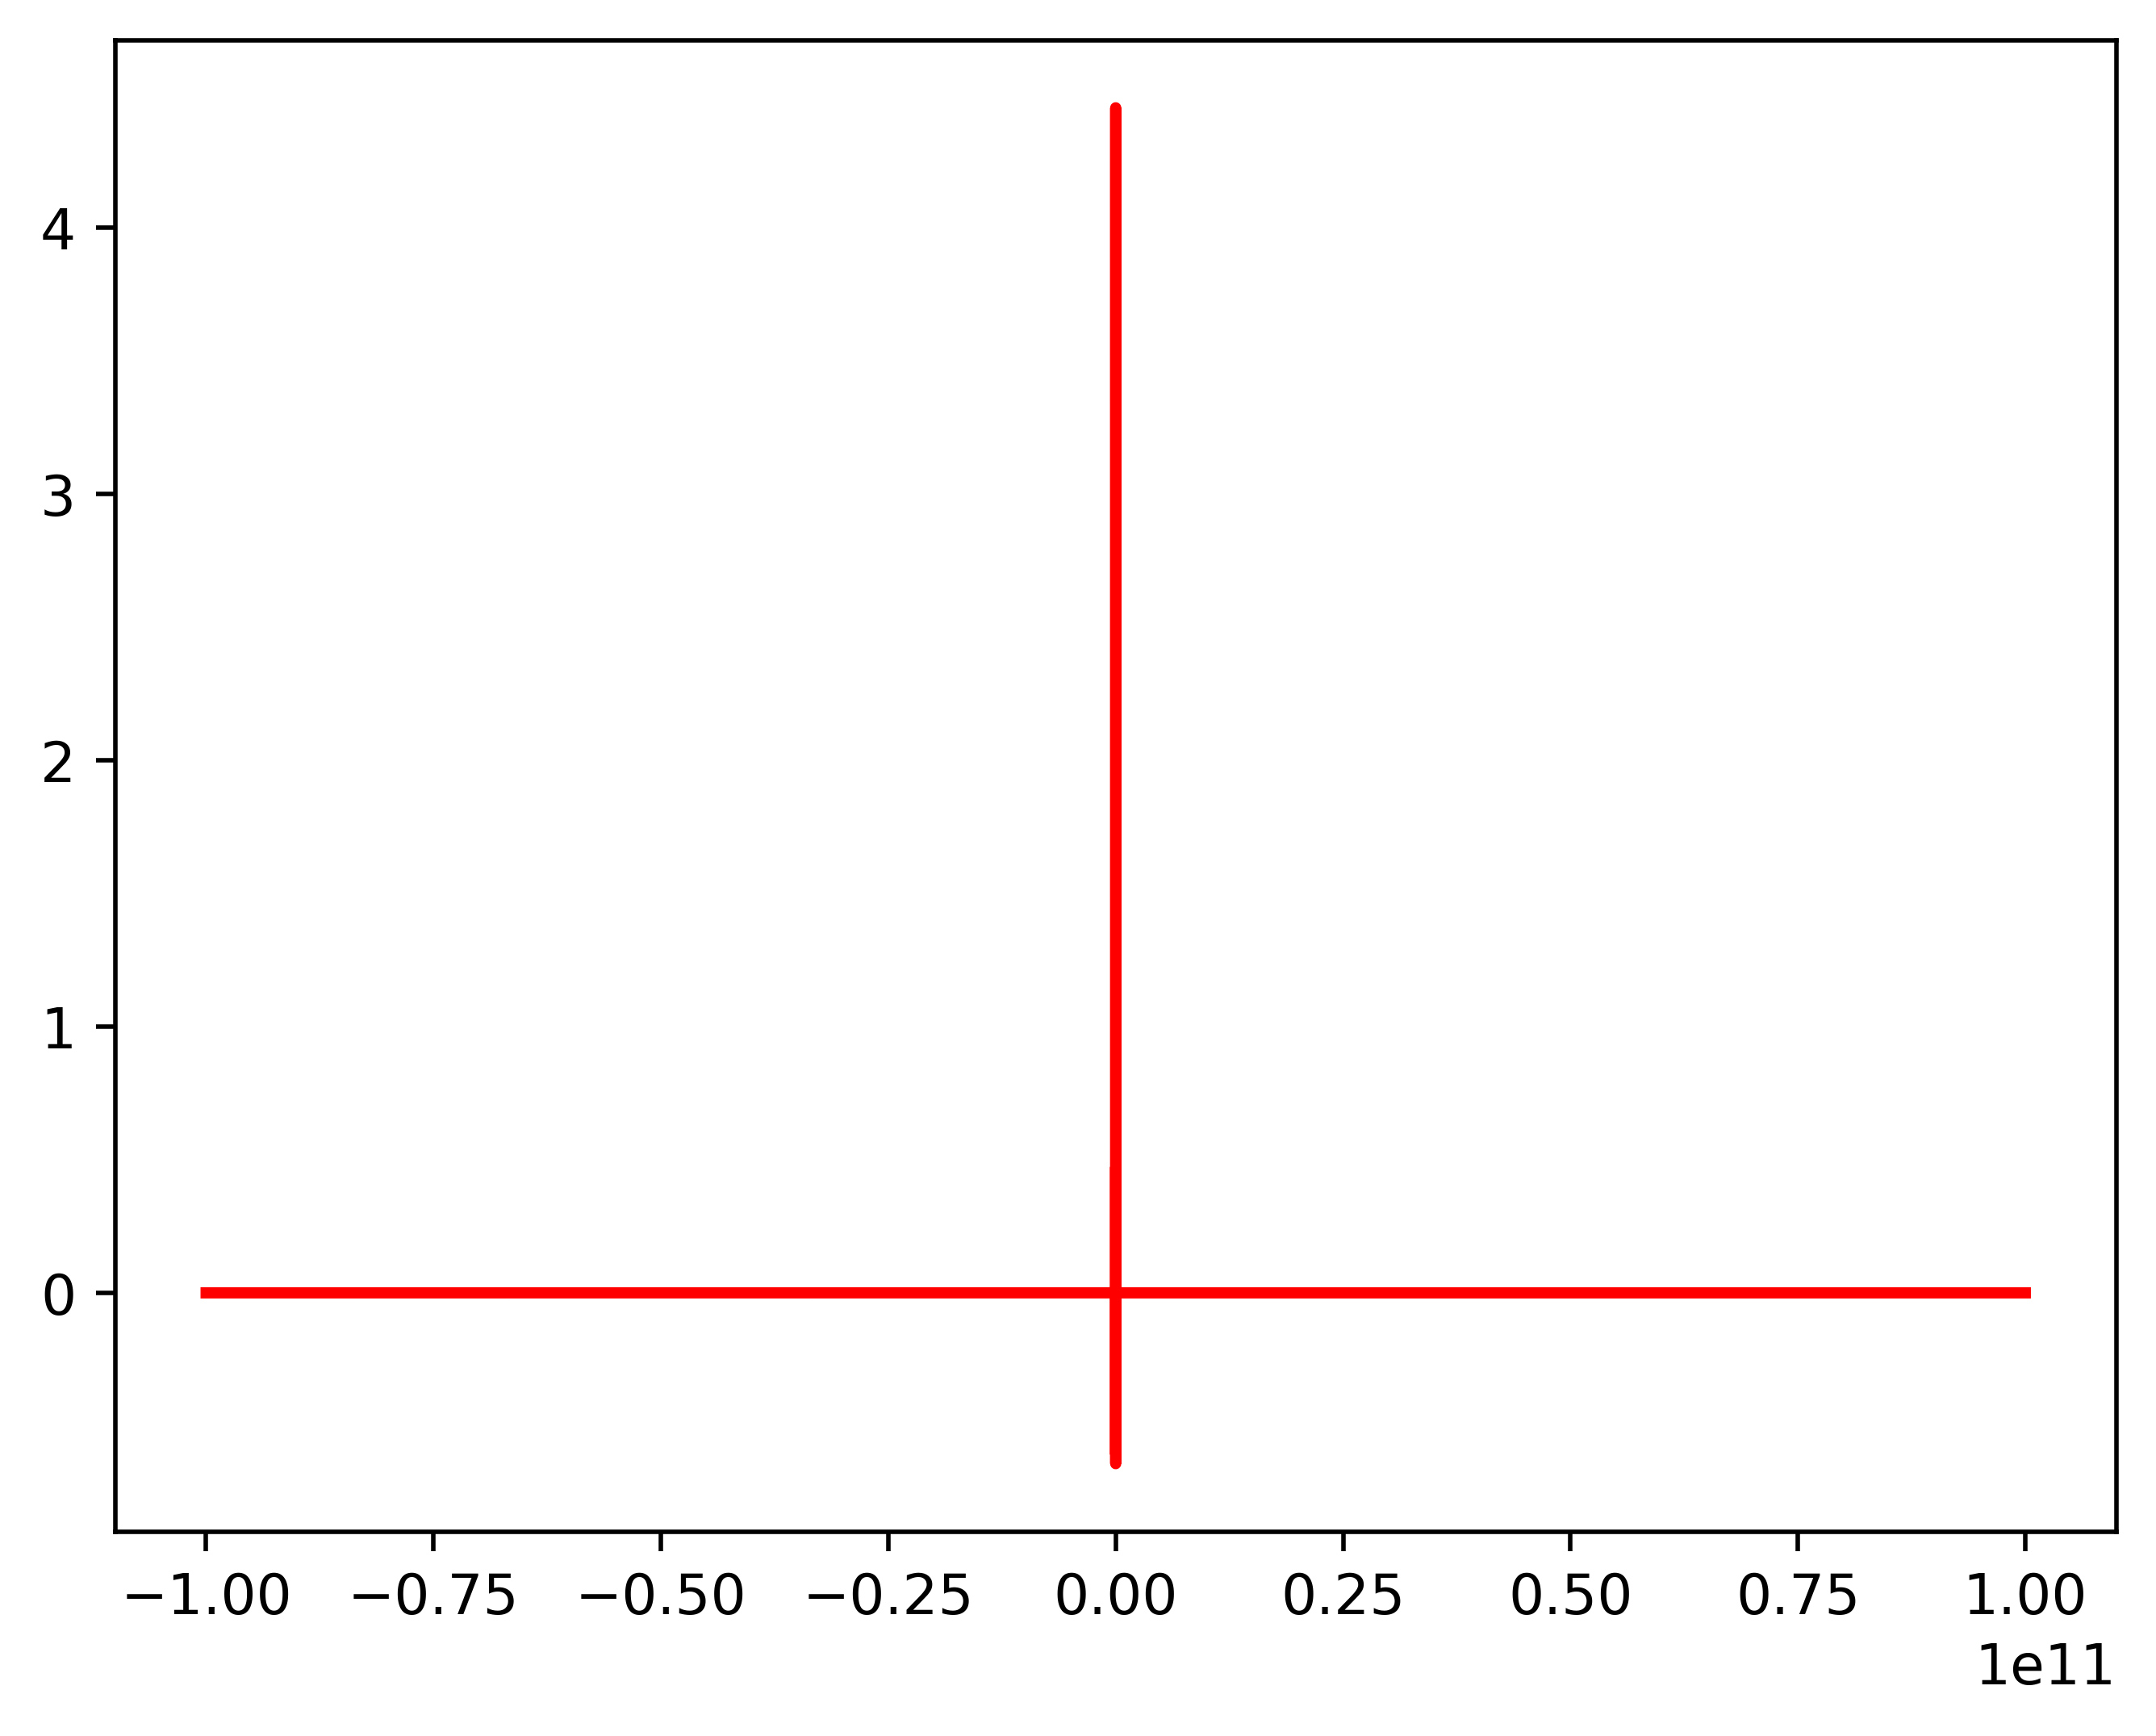

computation time is 10.48149561882019 seconds


In [9]:
#Choose the values of p as in paper section 5.1

import time
start_time = time.time()
L = 1
W =1

ny = 15
x1 = -np.logspace(0, 10, 50, endpoint=True)[::-1]*10
x2 = np.linspace(x1[-1], -x1[-1], 101)
x3 = np.logspace(0, 10, 50, endpoint=True)*10
p_i = np.concatenate((x1, x2, x3), axis=0)
XX = np.sort(p_i)
number_of_points = len(XX)
mesh = Geometry1(ny)
B = STOKE(mesh)
D_hom = D_star(XX, B, mesh)
fig = plt.figure(dpi=500)
plt.plot(XX, np.array(D_hom[2]), 'r-',  linewidth=2)
plt.show()
end_time = time.time() 
computation_time = (end_time-start_time)
print('computation time is', computation_time, 'seconds')


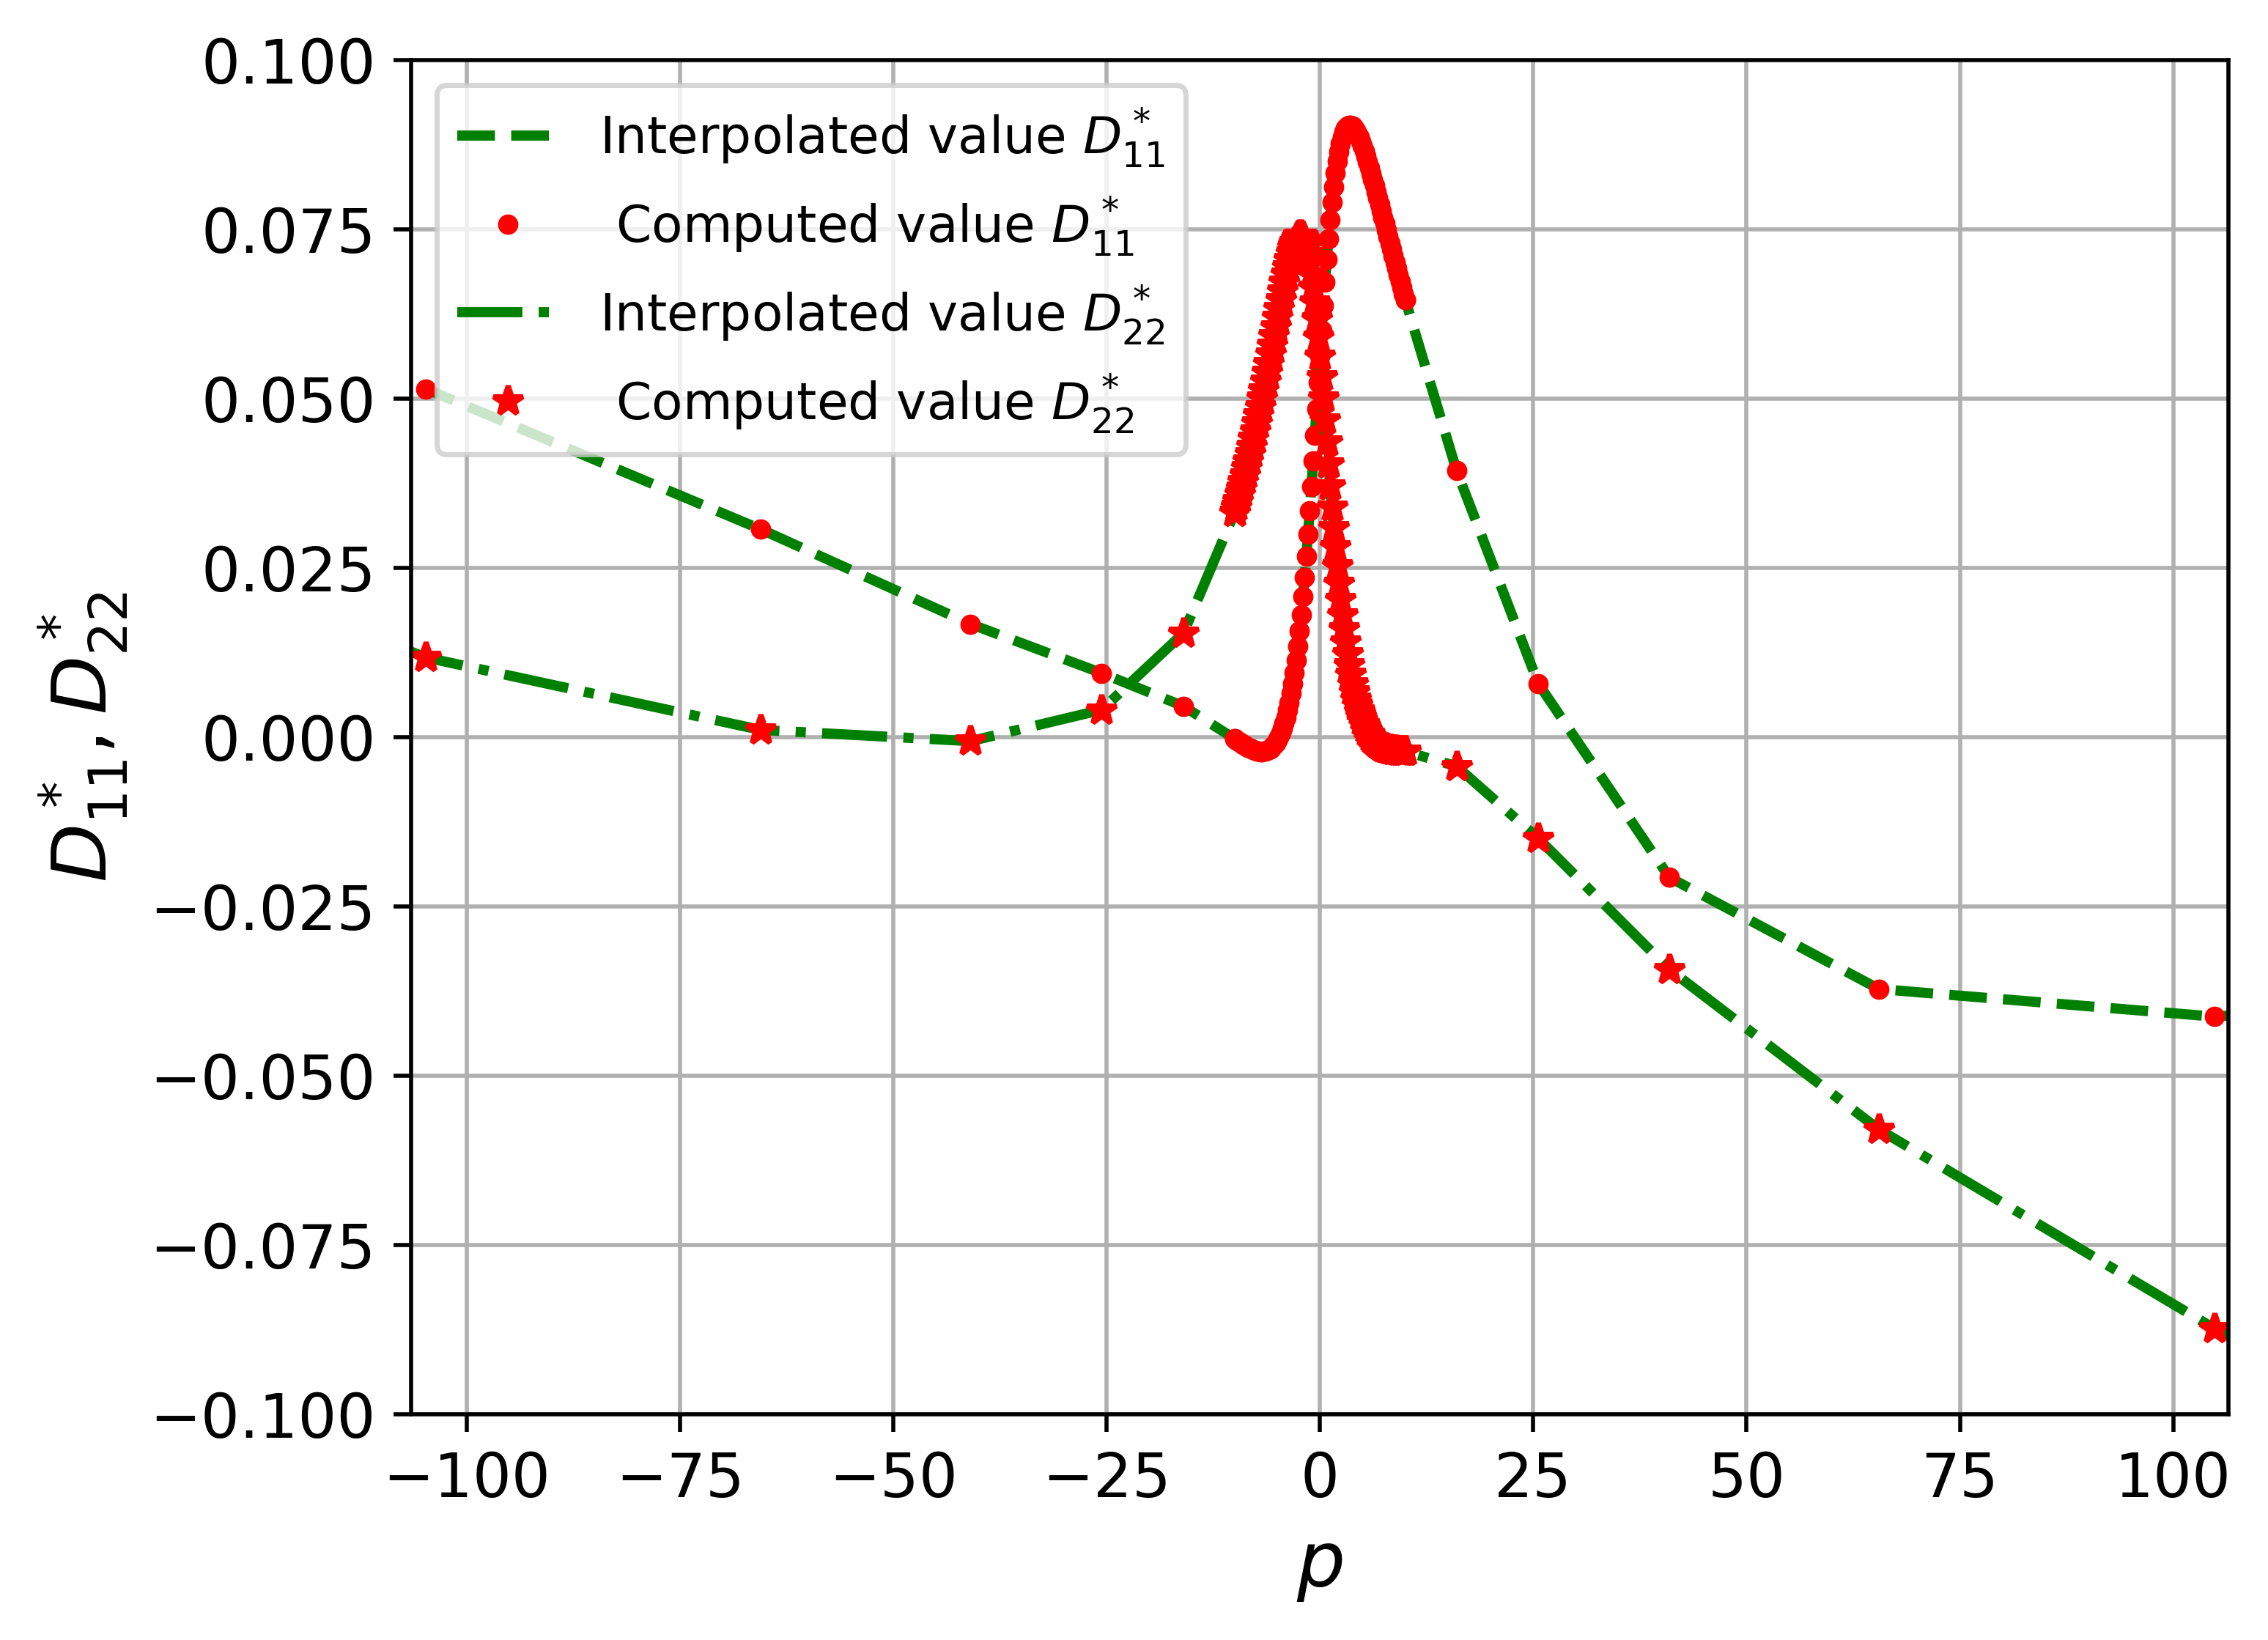

In [10]:
#ploting Figure 3 

fig = plt.figure(dpi=500)
plt.plot(XX, np.array(D_hom[1]), 'g--',  linewidth=2)
plt.plot(XX, np.array(D_hom[1]), 'r.',  linewidth=0.01)
plt.plot(XX, np.array(D_hom[2]), 'g-.',  linewidth=2)
plt.plot(XX, np.array(D_hom[2]), 'r *',  linewidth=0.01)
fontsize = 15
fontweight = 'normal'
fontproperties = {'weight' : fontweight, 'size' : fontsize}
plt.legend([r"Interpolated value $D^*_{11}$",r" Computed value $D^*_{11}$", r"Interpolated value $D^*_{22}$",r" Computed value $D^*_{22}$"], loc='upper left', frameon=True) # loc='upper left', frameon=False
#plt.legend([r"Interpolated value $D^*_{12}$",r" Computed value $D^*_{12}$", r"Interpolated value $D^*_{21}$",r" Computed value $D^*_{21}$"], loc='upper left', frameon=True)
plt.grid()
plt.xlabel('$p$', fontsize= fontsize, fontweight=fontweight)
plt.ylabel(r'$D^*_{11},  D^*_{22}$', fontsize= fontsize, fontweight=fontweight)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(np.min(XX), np.max(XX))
plt.xlim(-106.5,106.5)
#plt.ylim(1.1, 2.8)
plt.ylim(-0.1, 0.1)
plt.show()


In [11]:
#Scheme 2 Precomputing(for convergence order with only macro nodes vary) Section 5.3 Computational time and error 
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
import time
#U_scheme_2_pre = []
#for i in range(5):
start_time = time.time()
x_in = 0 
x_end = 1 
y_in = 0
y_end = 2
#nx = 16 #total nodes in x and y directions for macro domain (Omega)
T = 2 #
M = 20 # number of time steps (i.e., M+1 time nodes )
dt = T/M
Nxs = [4, 8, 16, 32, 64]
Hs_scheme2_precompute = []
U_FOR_MACRO_VARY_SCHEME2_PRE = []
for nx in Nxs:
    #u_in  = Constant(1.0) #intitlal iteration function 
    u_in =  Expression("exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
    #u_in = Expression("10*(sin(2*pi*x[0]))", degree =2)
    #f = Expression("1000*exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 0.5 )", degree =2)
    f = Expression("1000*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
    #f = Expression("10*(2 + (sin(2*pi*x[0])*sin(2*pi*x[1])))", degree =2)

    #f = Expression("exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))", degree =2)
    #f = Expression("2 + (cos(2*pi*x[0]*t)*sin(2*pi*x[1]*t))", t=0, degree =2) #time dependent right hand side
    #f = Expression("exp(-10*t*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))", t=0,  degree =2)
    #f = Constant(1)
    ###########
    Mesh = RectangleMesh(Point(x_in, y_in), Point(x_end, y_end), nx-1, nx-1) #mesh for u macro domain (Omega)
    print('H=', Mesh.hmax() )
    number_of_vertices = Mesh.num_vertices()
    Hs_scheme2_precompute.append(Mesh.hmax())
    print('number of vetrix=', number_of_vertices )
    V =  FunctionSpace(Mesh, 'Lagrange', 1) # finite element space with lagrange element of degree 1
    u_n = interpolate(u_in, V) #interpolation of initial iteration function on finite element space
    #u_n = u_0 #initial condition for each iteration 
    U_0 = u_n.compute_vertex_values(Mesh) # list of the iterpolated values of u_0
    #U_0_time = [U_0] # vertex values for each time step after  iterpolation the initial iteration function 
    def Boundary_condition(x, on_boundary):
        return on_boundary
    bc = DirichletBC(V, Constant(0.0), Boundary_condition) # zero Dirichlet boundary condition
    def G(u):
        return 1- 2*u
    #def G(u):
    #    return 1/(0.0001 + abs(1-2*u))
    UU_T =[]
    #UU_T.append(UU_0)
    #print(UU_T)
    UU_store = []
    u_store= []
    UU_store.append(u_n)
    u_store.append(U_0)
    t = 0
    ###Store value of D^* corresponding to some sapce point 
    #D_11_x_pre = []
    #D_12_x_pre = []
    #D_21_x_pre = []
    #D_22_x_pre = []
    for j in range(M):
        D_INTERPOLATE_11 = []
        D_INTERPOLATE_12 = []
        D_INTERPOLATE_21 = []
        D_INTERPOLATE_22 = []
        for i in range(number_of_vertices):
            #print(U_0[i])
            D_interpolate_11 = np.interp(G(U_0[i]), XX, D_hom[0])
            #print('D_11=', D_interpolate_11)
            D_interpolate_12 = np.interp(G(U_0[i]), XX, D_hom[1])
            D_interpolate_21 = np.interp(G(U_0[i]), XX, D_hom[2])
            D_interpolate_22 = np.interp(G(U_0[i]), XX, D_hom[3])
            D_INTERPOLATE_11.append(D_interpolate_11) 
            D_INTERPOLATE_12.append(D_interpolate_12) 
            D_INTERPOLATE_21.append(D_interpolate_21) 
            D_INTERPOLATE_22.append(D_interpolate_22)   
        d2v = dof_to_vertex_map(V) #A map that maps the dof to vetrix
        #print('number_of_vertices=', number_of_vertices)
        #print('number of vetrix in interpolated=', D_INTERPOLATE_11)
        #print(D_INTERPOLATE_11[int(nx/2*5)])
        # list of Vertex_values_D_11 in a way that FEniCS can define a fenics function from the discrete data of D_HOM_11, D_HOM_12,D_HOM_21, D_HOM_22 
        Vertex_values_D_11 = [D_INTERPOLATE_11[d2v[i]] for i in range(number_of_vertices)]   
        Vertex_values_D_12 = [D_INTERPOLATE_12[d2v[i]] for i in range(number_of_vertices)]
        Vertex_values_D_21 = [D_INTERPOLATE_21[d2v[i]] for i in range(number_of_vertices)]
        Vertex_values_D_22 = [D_INTERPOLATE_22[d2v[i]] for i in range(number_of_vertices)]

        ###initializing the each component of  D^* to a  function (componenetwise) in function space V
        D_star_11 = Function(V)
        D_star_12 = Function(V)
        D_star_21 = Function(V)
        D_star_22 = Function(V)

        ###assigning the discrete calculated values Vertex_values_D_11 to a function D_star_11 function. Similar for other components.
        D_star_11.vector()[:] = Vertex_values_D_11
        D_star_12.vector()[:] = Vertex_values_D_12
        D_star_21.vector()[:] = Vertex_values_D_21
        D_star_22.vector()[:] = Vertex_values_D_22 

        #construct a matrix from the component. we will use this mattrix D_star_k_plus_1 in macro problem.   
        D_star_k_plus_1 = as_matrix([[D_star_11,  D_star_12],[ D_star_21,  D_star_22]])
        #D_11_x_pre.append(D_star_k_plus_1[0, 0].compute_vertex_values(Mesh)[int(nx/2*9)])
        #D_12_x_pre.append(D_star_k_plus_1[0, 1].compute_vertex_values(Mesh)[int(nx/2*9)])
        #D_21_x_pre.append(D_star_k_plus_1[1, 0].compute_vertex_values(Mesh)[int(nx/2*9)])
        #D_22_x_pre.append(D_star_k_plus_1[1, 1].compute_vertex_values(Mesh)[int(nx/2*9)])
        #print(D_11_x_pre)
        t = t + dt
        #print(t)
        #f.t = t
        u = TrialFunction(V)
        v = TestFunction(V)
        #F = u*v*dx + dt*dot(D_star_k_plus_1_time[j]*grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
        F = u*v*dx + dt*dot(D_star_k_plus_1*grad(u), grad(v))*dx(domain=Mesh) - (u_n + dt*f)*v*dx(domain=Mesh) 
        a, L = lhs(F), rhs(F)
        u = Function(V)
        #t = t +dt
        solve(a == L, u, bc)
        #plt.colorbar(plot(u))
        #plt.show()
        UU_store.append(u)#store each time step solution u in UU_store list
        
        #Error.append(error**2)
        vertex_values_u = u.compute_vertex_values(Mesh) #compute the vertex value for each time step solution
        #print(vertex_values_u)
        u_store.append(vertex_values_u) #store the vertex values solution in u_store list
        u_n = u.copy() #assign the computed solution to a new u_n  
        U_0 =  vertex_values_u.copy()
        #print(U_0)
    U_FOR_MACRO_VARY_SCHEME2_PRE.append(UU_store) 
    end_time = time.time()
    print('computation time=', (end_time - start_time), 'seconds')

H= 0.74535599249993
number of vetrix= 16
computation time= 0.28954243659973145 seconds
H= 0.31943828249997
number of vetrix= 64
computation time= 0.6789383888244629 seconds
H= 0.1490711984999862
number of vetrix= 256
computation time= 1.6731452941894531 seconds
H= 0.07213122508063856
number of vetrix= 1024
computation time= 5.235079526901245 seconds
H= 0.035493142499996785
number of vetrix= 4096
computation time= 20.178293704986572 seconds


In [12]:
#compute error and convergence order
import math
#initialize error for shceme2 Hs_scheme2[i]/Hs_scheme2[i+1
Error_in_scheme2 = []
M = 20
for i in range(len(U_FOR_MACRO_VARY_SCHEME2_PRE)-1):
    print('i=', i)
    Errors_in_nx = []
    dt = T/M
    #print(dt)
    for j in range(M+1):
        error_in_time_slice = errornorm(U_FOR_MACRO_VARY_SCHEME2_PRE[i+1][j], U_FOR_MACRO_VARY_SCHEME2_PRE[i][j], norm_type ='L2')
        print(error_in_time_slice)
        Errors_in_nx.append(error_in_time_slice**2)
    Error_in_L_2_T = np.sqrt(dt*np.sum(Errors_in_nx))
    Error_in_scheme2.append(Error_in_L_2_T)  
print('Error_in_scheme2=', Error_in_scheme2)  

#Computing convergence rate
convergence_rate =[]
def convergence_order():
    for i in range(len(Error_in_scheme2)-1):
        rate = math.log(Error_in_scheme2[i]/Error_in_scheme2[i+1])/math.log(Hs_scheme2_precompute[i]/Hs_scheme2_precompute[i+1])
        convergence_rate.append(rate)
    return convergence_rate
RATE = convergence_order()
print('convergence order of scheme 2 =', RATE) 

i= 0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
0.21100337058942062
3.1293352284348814
3.382624726372581
3.4127663465373597
3.4130530377219324
3.411421529371847
3.410601347048737
3.4102927493061883
3.4101890473713277
3.4101561757642833
3.410146126268037
3.410143127487816
3.4101422478345826
3.410141993014137
3.4101419198889174
3.410141899055042
3.410141893152437
3.4101418914874473
3.410141891019416
3.4101418908882177
3.410141890851519
i= 1
0.10331573472391346
1.0532902979996603
1.140245322979868
1.1562524462925483
1.1592688252570589
1.1598099188642088
1.1598928576559178
1.1599000708093195
1.1598981868208653
1.1598967613534605
1.1598961504479812
1.1598959288019375
1.1598958545625586
1.1598958308252558
1.1598958234591514
1.1598958212196206
1.1598958205485626
1.1598958203495942
1.1598958202910519
1.1598958202739402
1.1598958202689553
i= 

In [ ]:
#Figure 6, First compute both  errors and then plot in loglog plot with H values 
import numpy as np
import matplotlib.pyplot as plt
#convergence order in scheme 2
#H_space = np.load('Two_scale_paper2/Scheme1_precompute_macro_vary/scheme1_precompute_Hs_nx_48163264_M_20nxmicro_15.npy')
Error_scheme2= [4.802365900020514, 1.6308094147427143, 0.4141075685854903, 0.16677979711037397]
Error_scheme2_pre = [4.804463, 1.632296290, 0.416212306, 0.16712954]
Error_scheme1 = [4.8023658 , 1.6308094, 0.4155008, 0.1678484]
Error_scheme1_pre = [4.804463  , 1.632296, 0.416212,  0.1671295]
#plt.plot(np.log(NX[:-1]), np.log(Error_scheme1), '--')
#plt.plot(np.log(NX[:-1]), np.log(Error_scheme1_pre), '-.')
plt.figure(dpi=500)
#plt.plot(np.log(NX[:-1]), np.log(Error_scheme2), 'r-o', linewidth=2)
plt.plot(np.log(H_space[1:]), np.log(Error_scheme2_pre), 'r-o', linewidth=2)
#plt.plot(np.log(H_space[1:]), np.log(Error_scheme2), 'r-o', linewidth=2)
plt.plot(np.log(H_space[1:]), 2*np.log(H_space[1:]), 'g--', linewidth=2)
#plt.plot(np.log(NX[:-1]), np.log(Error_scheme1), 'r-o', linewidth=2)
#plt.plot(np.log(NX[:-1]), np.log(Error_scheme1_pre), 'r-o', linewidth=2)
#plt.plot(np.log(NX[:-1]), -2.*np.log(NX[:-1]), 'g--', linewidth=2)
plt.legend([r'error', r'slope 2'])
plt.title('Scheme 2 (precomputing)')
plt.xlabel(r'log(H)')
plt.ylabel('log(error)')
plt.grid()
plt.show()
